In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thesis/Dataset (S/validation/labels/0566.png
/kaggle/input/thesis/Dataset (S/validation/labels/0133.png
/kaggle/input/thesis/Dataset (S/validation/labels/0006.png
/kaggle/input/thesis/Dataset (S/validation/labels/0516.png
/kaggle/input/thesis/Dataset (S/validation/labels/0003.png
/kaggle/input/thesis/Dataset (S/validation/labels/0217.png
/kaggle/input/thesis/Dataset (S/validation/labels/0816.png
/kaggle/input/thesis/Dataset (S/validation/labels/0337.png
/kaggle/input/thesis/Dataset (S/validation/labels/0835.png
/kaggle/input/thesis/Dataset (S/validation/labels/0096.png
/kaggle/input/thesis/Dataset (S/validation/labels/0451.png
/kaggle/input/thesis/Dataset (S/validation/labels/0301.png
/kaggle/input/thesis/Dataset (S/validation/labels/0947.png
/kaggle/input/thesis/Dataset (S/validation/labels/0405.png
/kaggle/input/thesis/Dataset (S/validation/labels/0341.png
/kaggle/input/thesis/Dataset (S/validation/labels/0208.png
/kaggle/input/thesis/Dataset (S/validation/labels/0369.p

# 1. Cài đặt thư viện

In [3]:
!pip install -q segmentation-models-pytorch albumentations timm opencv-python-headless numpy scikit-image matplotlib grad-cam

# 2. Import các thư viện
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os

# Import thư viện model
import segmentation_models_pytorch as smp

# Import thư viện xử lý ảnh (transform)
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Import thư viện cho GLCM (phân tích gồ ghề)
from skimage.feature import graycomatrix, graycoprops

# Import thư viện cho Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

print("Cell 1: Thư viện cho Notebook mới đã sẵn sàng!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.1 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 89.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Cell 1: Thư viện cho Notebook mới đã sẵn sàng!


# 1. Định nghĩa Config (chỉ những gì cần cho inference)

In [4]:
class CFG:
    IMG_SIZE = 512
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Sử dụng device: {CFG.DEVICE}")
print(f"Sử dụng IMG_SIZE: {CFG.IMG_SIZE}")


# 2. Định nghĩa lại transform DÙNG CHO INFERENCE
# (Giống hệt transform lúc validation)
inference_transform = A.Compose([
    A.Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])
print("Đã tạo 'inference_transform'.")


# 3. Khởi tạo cấu trúc model và Load weights

MODEL_PATH = "/kaggle/input/model-trained/Model Trained/SegFormerB3_NoAug_best_no_aug (1).pth" # Sửa đường dẫn này

# Kiểm tra xem file có tồn tại không
if not os.path.exists(MODEL_PATH):
    print(f"LỖI: Không tìm thấy file model tại '{MODEL_PATH}'")
    print("Vui lòng kiểm tra lại đường dẫn và upload file .pth lên Kaggle.")
    # Sẽ báo lỗi ở đây nếu sếp không sửa đường dẫn
    
# Phải định nghĩa lại model y hệt lúc train
model_inference = smp.Unet(
    encoder_name="mit_b3",
    encoder_weights=None, # Đặt là None vì ta sẽ load file pth
    in_channels=3,
    classes=1,
)

# 4. Load weights đã train
try:
    model_inference.load_state_dict(torch.load(MODEL_PATH, map_location=CFG.DEVICE))
    model_inference.to(CFG.DEVICE)
    model_inference.eval() # BẬT CHẾ ĐỘ INFERENCE
    print(f"✅✅✅ Sẵn sàng! Đã load model từ {MODEL_PATH}")
except Exception as e:
    print(f"LỖI KHI LOAD MODEL: {e}")
    print("Nếu lỗi 'No such file or directory', sếp hãy sửa MODEL_PATH ở trên.")

Sử dụng device: cuda
Sử dụng IMG_SIZE: 512
Đã tạo 'inference_transform'.
✅✅✅ Sẵn sàng! Đã load model từ /kaggle/input/model-trained/Model Trained/SegFormerB3_NoAug_best_no_aug (1).pth


Đã load và transform ảnh: /kaggle/input/thesis/Dataset (S/test/images/1343.png
Kích thước tensor đầu vào: torch.Size([1, 3, 512, 512])
Đã tạo predicted mask, kích thước: (512, 512)


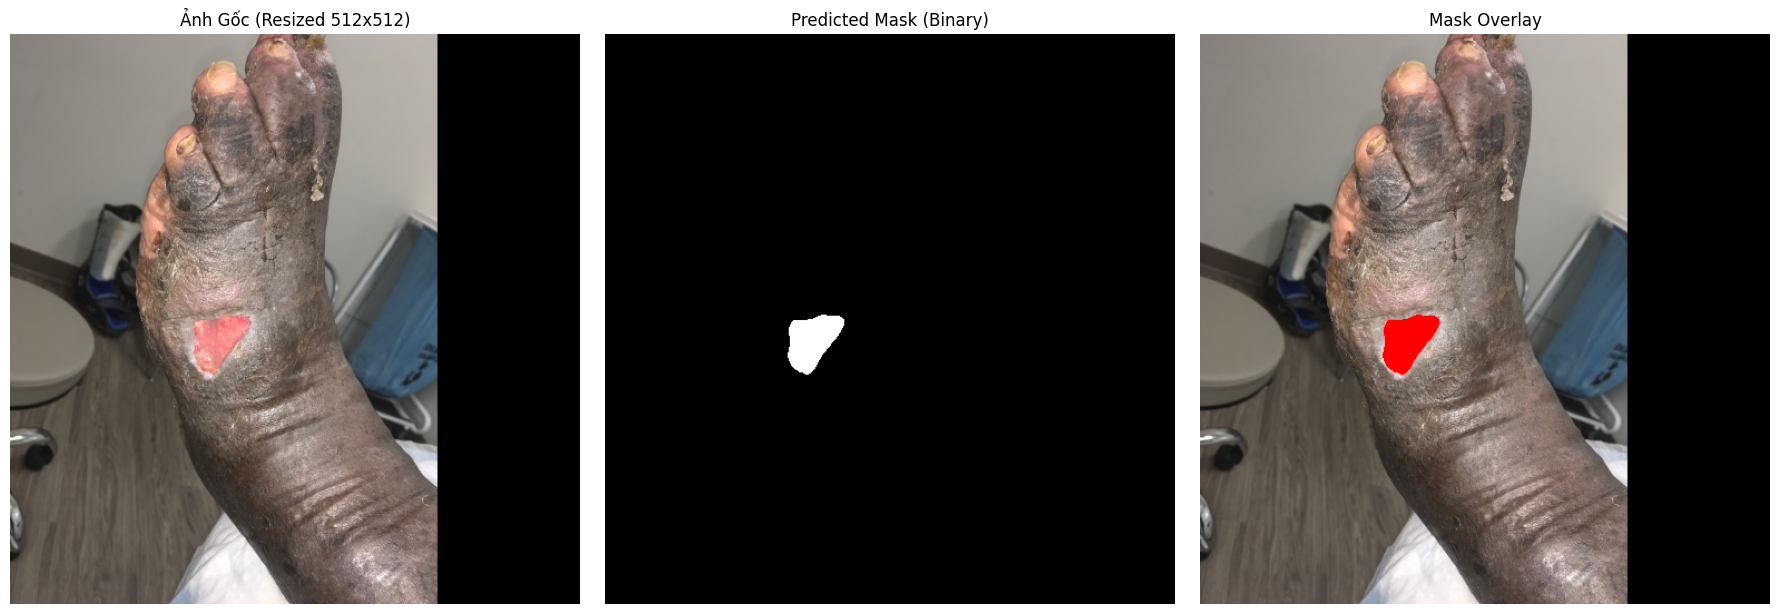

In [5]:
TEST_IMAGE_PATH = "/kaggle/input/thesis/Dataset (S/test/images/1343.png" # Sửa đường dẫn này

# 1. Hàm để load và xử lý ảnh (VÁ LỖI)
def load_and_transform_image(image_path):
    if not os.path.exists(image_path):
        print(f"LỖI 1: Không tìm thấy đường dẫn '{image_path}'")
        return None, None

    original_image = cv2.imread(image_path)
    
    if original_image is None:
        print(f"LỖI 2: cv2.imread không thể đọc được file tại: '{image_path}'")
        print("Lý do: File hỏng, hoặc đường dẫn sai (có thể có ký tự lạ).")
        return None, None
            
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    transformed = inference_transform(image=original_image)
    input_tensor = transformed["image"]
    input_tensor = input_tensor.unsqueeze(0).to(CFG.DEVICE)
    
    print(f"Đã load và transform ảnh: {image_path}")
    print(f"Kích thước tensor đầu vào: {input_tensor.shape}")
    
    return original_image, input_tensor

# 2. Hàm để chạy prediction (Giữ nguyên)
@torch.no_grad()
def get_prediction_mask(input_tensor):
    if input_tensor is None:
        return None
        
    logits = model_inference(input_tensor)
    probabilities = torch.sigmoid(logits)
    predicted_mask = (probabilities > 0.5).float()
    predicted_mask = predicted_mask.squeeze().cpu().numpy()
    
    print(f"Đã tạo predicted mask, kích thước: {predicted_mask.shape}")
    return predicted_mask

# 3. Chạy thực tế
original_image, input_tensor = load_and_transform_image(TEST_IMAGE_PATH)
predicted_mask = get_prediction_mask(input_tensor)

# 4. Hiển thị kết quả
if predicted_mask is not None and original_image is not None:
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    original_resized = cv2.resize(original_image, (CFG.IMG_SIZE, CFG.IMG_SIZE))
    
    ax[0].imshow(original_resized)
    ax[0].set_title(f"Ảnh Gốc (Resized {CFG.IMG_SIZE}x{CFG.IMG_SIZE})")
    ax[0].axis("off")
    
    ax[1].imshow(predicted_mask, cmap='gray')
    ax[1].set_title("Predicted Mask (Binary)")
    ax[1].axis("off")

    # Hiển thị mask đè lên ảnh gốc
    overlay = original_resized.copy()
    
    # === SỬA LỖI VALUEERROR TẠI ĐÂY ===
    # 1. KHÔNG cần tạo mask_3d
    # 2. Dùng thẳng predicted_mask (2D) để chọn pixel trên overlay (3D)
    
    # `predicted_mask > 0` sẽ chọn ra các pixel (H, W)
    # NumPy sẽ tự động gán cả 3 kênh (R, G, B) của pixel đó
    overlay[predicted_mask > 0] = (255, 0, 0) # Tô màu đỏ vào vùng mask
    # ==================================
    
    ax[2].imshow(overlay)
    ax[2].set_title("Mask Overlay")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("Không thể hiển thị. Vui lòng kiểm tra lại lỗi ở trên.")

In [6]:
# Cell này sẽ cài thêm pandas, tqdm, và scikit-learn
!pip install -q pandas tqdm scikit-learn
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
import random
from sklearn.utils import shuffle

print("--- BƯỚC 1: LẤY MẪU PIXEL (TỪ TRAIN+VALID) ---")

# --- PHẦN 1: CÁC HÀM TIỆN ÍCH ---

# 1. Config (lấy từ Cell 2)
if 'CFG' not in globals():
    class CFG:
        IMG_SIZE = 512 # Lấy lại từ Cell 2
        DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Sẽ resize ảnh/mask về: {CFG.IMG_SIZE}x{CFG.IMG_SIZE}")

# 2. ⚠️ SỬA ĐƯỜNG DẪN DATA GỐC
DATA_DIR = "/kaggle/input/thesis/Dataset (S" # Sửa lại nếu cần

# 3. Hàm tiện ích để tìm các cặp (ảnh, mask)
def find_all_pairs(data_dir):
    all_pairs = []
    splits = ["train", "validation"]
    for split in splits:
        image_dir = os.path.join(data_dir, split, "images")
        mask_dir_name = "masks" # Giả định tên
        if not os.path.exists(os.path.join(data_dir, split, mask_dir_name)):
             mask_dir_name = "labels"
        mask_dir = os.path.join(data_dir, split, mask_dir_name)
        if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
            print(f"Cảnh báo: Không tìm thấy thư mục images/masks cho split '{split}'")
            continue
        print(f"Đang quét {split}...")
        image_paths = sorted(glob(os.path.join(image_dir, "*")))
        for img_path in image_paths:
            base_name_no_ext = os.path.splitext(os.path.basename(img_path))[0]
            found_mask = None
            for ext in [".png", ".jpg", ".jpeg"]:
                mask_cand = os.path.join(mask_dir, base_name_no_ext + ext)
                if os.path.exists(mask_cand):
                    found_mask = mask_cand
                    break
            if found_mask:
                all_pairs.append((img_path, found_mask, split))
    return all_pairs

# --- PHẦN 2: CHẠY VÒNG LẶP (CHỈ ĐỂ "HÚT" PIXEL) ---

# 1. Tạo danh sách 1000+ cặp file
all_image_pairs = find_all_pairs(DATA_DIR)
print(f"\nTổng cộng tìm thấy: {len(all_image_pairs)} cặp (ảnh, mask).")

# 2. Vòng lặp "hút" pixel
all_wound_pixels = [] # Nơi gom pixel từ 1000+ ảnh

for img_path, mask_path, split in tqdm(all_image_pairs, desc="Hút pixel từ Train/Valid"):
    try:
        # 2a. Load Ảnh và Mask (DÙNG LABEL THẬT)
        image_bgr = cv2.imread(img_path)
        mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image_bgr is None or mask_gray is None:
            continue

        # 2b. Resize
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image_rgb, (CFG.IMG_SIZE, CFG.IMG_SIZE), 
                                   interpolation=cv2.INTER_LANCZOS4)
        mask_resized = cv2.resize(mask_gray, (CFG.IMG_SIZE, CFG.IMG_SIZE), 
                                  interpolation=cv2.INTER_NEAREST)
        
        # 2c. Lấy mask (boolean)
        mask_bool = (mask_resized > 0)
        
        # 2d. "Hút" pixel
        current_pixels = image_resized[mask_bool] # Shape (N, 3)
        
        if len(current_pixels) > 0:
            all_wound_pixels.append(current_pixels)
        
    except Exception as e:
        print(f"Lỗi khi xử lý file {img_path}: {e}")

print(f"\nĐã gom pixel từ {len(all_wound_pixels)} vết loét (ảnh).")

# --- PHẦN 3: TỔNG HỢP MẪU "PHỔ QUÁT" ---

if not all_wound_pixels:
    print("LỖI: Không hút được pixel nào. Kiểm tra lại đường dẫn.")
else:
    # 1. Gom tất cả lại thành 1 mảng numpy khổng lồ
    pixel_mega_array = np.concatenate(all_wound_pixels, axis=0)
    print(f"Tổng cộng đã hút được: {len(pixel_mega_array)} pixels.")
    
    # 2. Lấy mẫu cuối cùng
    # Chạy Elbow/Silhouette trên 500k pixel là đủ
    FINAL_SAMPLE_SIZE = 500000 
    
    if len(pixel_mega_array) > FINAL_SAMPLE_SIZE:
        print(f"Lấy mẫu ngẫu nhiên {FINAL_SAMPLE_SIZE} pixels từ tổng...")
        # Dùng shuffle của sklearn cho hiệu quả
        final_pixel_sample = shuffle(pixel_mega_array, 
                                     random_state=42)[:FINAL_SAMPLE_SIZE]
    else:
        print("Lấy toàn bộ pixel làm mẫu.")
        final_pixel_sample = pixel_mega_array
        
    print(f"✅ Hoàn tất Bước 1! Đã có mẫu 'phổ quát' với {len(final_pixel_sample)} pixels.")
    print("Biến 'final_pixel_sample' đã sẵn sàng cho Bước 2.")

--- BƯỚC 1: LẤY MẪU PIXEL (TỪ TRAIN+VALID) ---
Sẽ resize ảnh/mask về: 512x512
Đang quét train...
Đang quét validation...

Tổng cộng tìm thấy: 1010 cặp (ảnh, mask).


Hút pixel từ Train/Valid: 100%|██████████| 1010/1010 [00:23<00:00, 42.95it/s]



Đã gom pixel từ 986 vết loét (ảnh).
Tổng cộng đã hút được: 3374008 pixels.
Lấy mẫu ngẫu nhiên 500000 pixels từ tổng...
✅ Hoàn tất Bước 1! Đã có mẫu 'phổ quát' với 500000 pixels.
Biến 'final_pixel_sample' đã sẵn sàng cho Bước 2.


In [8]:
# === BƯỚC 2: RGB -> HSV & CHUẨN HÓA CHO K-MEANS ===

import numpy as np
import cv2

print("--- BƯỚC 2: CONVERT RGB -> HSV & TẠO FEATURE ---")

# 1. Kiểm tra xem đã có mẫu pixel chưa
if 'final_pixel_sample' not in globals():
    raise ValueError("❌ final_pixel_sample chưa tồn tại. Nhớ chạy Bước 1 trước đã!")

# 2. Đảm bảo kiểu dữ liệu đúng cho OpenCV
# final_pixel_sample shape: (N, 3), mỗi row = [R, G, B]
pixels_rgb = final_pixel_sample.astype(np.uint8)

print(f"Số pixel mẫu đang có: {pixels_rgb.shape[0]}")

# 3. Reshape để dùng cv2.cvtColor (cần shape (N, 1, 3))
pixels_rgb_reshaped = pixels_rgb.reshape(-1, 1, 3)

# 4. Convert RGB -> HSV (OpenCV dùng Hue: 0–179, S/V: 0–255)
pixels_hsv_reshaped = cv2.cvtColor(pixels_rgb_reshaped, cv2.COLOR_RGB2HSV)
pixels_hsv = pixels_hsv_reshaped.reshape(-1, 3)

# 5. In thử vài pixel để xem RGB vs HSV như thế nào
print("\nVí dụ 5 pixel đầu tiên (RGB -> HSV):")
print("RGB:")
print(pixels_rgb[:5])
print("HSV (H,S,V):")
print(pixels_hsv[:5])

# 6. Chuẩn hóa HSV về [0,1] để dùng cho K-means / ML
#    - OpenCV: H ∈ [0,179], S ∈ [0,255], V ∈ [0,255]
h = pixels_hsv[:, 0].astype(np.float32) / 179.0
s = pixels_hsv[:, 1].astype(np.float32) / 255.0
v = pixels_hsv[:, 2].astype(np.float32) / 255.0

# 7. Ghép lại thành feature matrix X_hsv (N, 3)
X_hsv = np.stack([h, s, v], axis=1)

print(f"\n✅ Đã tạo feature HSV cho K-means với shape: {X_hsv.shape}")
print("   Mỗi row = [H_norm, S_norm, V_norm] ∈ [0,1]")

# 8. (Optional) Lưu ra file để xài ở notebook khác / bước sau
np.save("wound_pixels_hsv_sample.npy", X_hsv)
print("\n💾 Đã lưu feature HSV vào file: 'wound_pixels_hsv_sample.npy'")
print("   Bước tiếp theo: chạy K-means trên X_hsv (Bước 3).")


--- BƯỚC 2: CONVERT RGB -> HSV & TẠO FEATURE ---
Số pixel mẫu đang có: 500000

Ví dụ 5 pixel đầu tiên (RGB -> HSV):
RGB:
[[166 105 111]
 [175  67  41]
 [187  96 122]
 [156  76  66]
 [ 44  17  16]]
HSV (H,S,V):
[[177  94 166]
 [  6 195 175]
 [171 124 187]
 [  3 147 156]
 [  1 162  44]]

✅ Đã tạo feature HSV cho K-means với shape: (500000, 3)
   Mỗi row = [H_norm, S_norm, V_norm] ∈ [0,1]

💾 Đã lưu feature HSV vào file: 'wound_pixels_hsv_sample.npy'
   Bước tiếp theo: chạy K-means trên X_hsv (Bước 3).


--- BƯỚC 3: K-MEANS TRÊN PIXEL HSV (COLOR CLUSTERING) ---
Tổng số pixel trong X_hsv: 500000
Lấy mẫu ngẫu nhiên 100000 pixel để chạy Elbow/Silhouette...
Shape mẫu dùng cho K-means: (100000, 3)

Đang chạy K-means cho các K: [2, 3, 4, 5, 6]
  -> Đang fit KMeans với K = 2 ...
  -> Đang fit KMeans với K = 3 ...
  -> Đang fit KMeans với K = 4 ...
  -> Đang fit KMeans với K = 5 ...
  -> Đang fit KMeans với K = 6 ...

Kết quả Elbow (Inertia) & Silhouette:
K = 2: inertia = 7573.32, silhouette = 0.6664
K = 3: inertia = 4588.75, silhouette = 0.4968
K = 4: inertia = 3899.97, silhouette = 0.4619
K = 5: inertia = 3229.42, silhouette = 0.3838
K = 6: inertia = 2681.06, silhouette = 0.3512


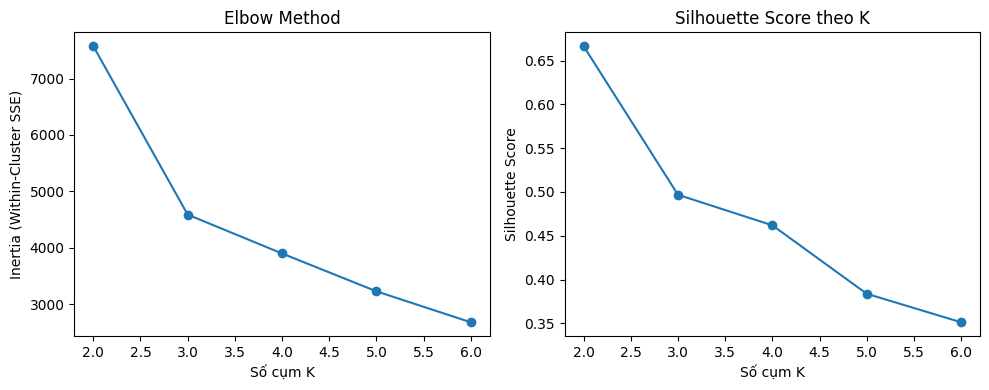


💡 Gợi ý:
- Thường với DFU color risk, người ta hay chọn khoảng K = 3 (đỏ / vàng / sậm/trắng).
- Nhưng mày nên nhìn Elbow + Silhouette rồi quyết định K hợp lý cho dataset của mày.

--- TRAIN KMEANS FINAL VỚI K = 3 TRÊN TOÀN BỘ X_hsv ---
✅ Đã train xong KMeans final.
Shape cluster_centers_hsv: (3, 3)
Các tâm cụm (H_norm, S_norm, V_norm) trong [0,1]:
[[0.98634744 0.5814496  0.61258453]
 [0.04304849 0.45104897 0.78280985]
 [0.04389425 0.5275147  0.38976485]]

💾 Đã lưu model KMeans vào 'kmeans_ulcer_color_hsv.pkl'
   và tâm cụm vào 'kmeans_ulcer_color_centers_hsv.npy'.


In [9]:
# === BƯỚC 3: K-MEANS COLOR CLUSTERING TRÊN X_hsv ===
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

print("--- BƯỚC 3: K-MEANS TRÊN PIXEL HSV (COLOR CLUSTERING) ---")

# 1. Kiểm tra dữ liệu đầu vào
if 'X_hsv' not in globals():
    raise ValueError("❌ X_hsv chưa tồn tại. Nhớ chạy Bước 2 (RGB -> HSV) trước!")

N = X_hsv.shape[0]
print(f"Tổng số pixel trong X_hsv: {N}")

# 2. Lấy mẫu con cho việc tìm số cụm (cho đỡ nặng)
MAX_SAMPLE_FOR_K = 100000  # mày có thể chỉnh lên/xuống
if N > MAX_SAMPLE_FOR_K:
    print(f"Lấy mẫu ngẫu nhiên {MAX_SAMPLE_FOR_K} pixel để chạy Elbow/Silhouette...")
    idx = np.random.choice(N, size=MAX_SAMPLE_FOR_K, replace=False)
    X_sample = X_hsv[idx]
else:
    print("Dùng toàn bộ X_hsv để chạy Elbow/Silhouette.")
    X_sample = X_hsv

print(f"Shape mẫu dùng cho K-means: {X_sample.shape}")

# 3. Thử nhiều giá trị K để xem Elbow + Silhouette
K_list = [2, 3, 4, 5, 6]
inertias = []
sil_scores = []

print("\nĐang chạy K-means cho các K:", K_list)
for K in K_list:
    print(f"  -> Đang fit KMeans với K = {K} ...")
    kmeans_tmp = KMeans(
        n_clusters=K,
        random_state=42,
        n_init=10
    )
    labels_tmp = kmeans_tmp.fit_predict(X_sample)
    inertias.append(kmeans_tmp.inertia_)
    
    # Silhouette chỉ meaningful khi K > 1
    if K > 1:
        sil = silhouette_score(X_sample, labels_tmp)
    else:
        sil = np.nan
    sil_scores.append(sil)

print("\nKết quả Elbow (Inertia) & Silhouette:")
for K, inertia, sil in zip(K_list, inertias, sil_scores):
    print(f"K = {K}: inertia = {inertia:.2f}, silhouette = {sil:.4f}")

# 4. Vẽ Elbow & Silhouette cho dễ nhìn (optional)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(K_list, inertias, marker='o')
plt.xlabel("Số cụm K")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(K_list, sil_scores, marker='o')
plt.xlabel("Số cụm K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score theo K")

plt.tight_layout()
plt.show()

print("\n💡 Gợi ý:")
print("- Thường với DFU color risk, người ta hay chọn khoảng K = 3 (đỏ / vàng / sậm/trắng).")
print("- Nhưng mày nên nhìn Elbow + Silhouette rồi quyết định K hợp lý cho dataset của mày.")

# 5. TRAIN MÔ HÌNH KMEANS CUỐI CÙNG VỚI K ĐÃ CHỌN
#    (Ở đây tao để default là 3, mày có thể đổi sau khi xem plot)
BEST_K = 3
print(f"\n--- TRAIN KMEANS FINAL VỚI K = {BEST_K} TRÊN TOÀN BỘ X_hsv ---")

kmeans_final = KMeans(
    n_clusters=BEST_K,
    random_state=42,
    n_init=10
)
cluster_labels_full = kmeans_final.fit_predict(X_hsv)
cluster_centers_hsv = kmeans_final.cluster_centers_

print("✅ Đã train xong KMeans final.")
print(f"Shape cluster_centers_hsv: {cluster_centers_hsv.shape}")
print("Các tâm cụm (H_norm, S_norm, V_norm) trong [0,1]:")
print(cluster_centers_hsv)

# 6. (Optional) Lưu model/tâm cụm để dùng ở bước risk level
import joblib
joblib.dump(kmeans_final, "kmeans_ulcer_color_hsv.pkl")
np.save("kmeans_ulcer_color_centers_hsv.npy", cluster_centers_hsv)

print("\n💾 Đã lưu model KMeans vào 'kmeans_ulcer_color_hsv.pkl'")
print("   và tâm cụm vào 'kmeans_ulcer_color_centers_hsv.npy'.")

# Sau này mày có thể load lại:
# kmeans_loaded = joblib.load("kmeans_ulcer_color_hsv.pkl")


In [11]:
# === BƯỚC 2 + 3 GỘP: RGB -> HSV + KMEANS K=3 ===
import numpy as np
import cv2
from sklearn.cluster import KMeans
import joblib
import pandas as pd

print("--- BƯỚC 2+3: RGB -> HSV & KMEANS K=3 TRÊN TOÀN BỘ PIXEL ---")

# 1. Kiểm tra final_pixel_sample (từ Bước 1)
if 'final_pixel_sample' not in globals():
    raise ValueError("❌ final_pixel_sample chưa tồn tại. Nhớ chạy cell hút pixel (Bước 1) trước!")

# 2. Chuẩn bị pixel RGB
pixels_rgb = final_pixel_sample.astype(np.uint8)  # shape (N, 3)
N = pixels_rgb.shape[0]
print(f"Số pixel mẫu đang có: {N}")

# 3. RGB -> HSV (OpenCV: H∈[0,179], S,V∈[0,255])
pixels_rgb_reshaped = pixels_rgb.reshape(-1, 1, 3)
pixels_hsv_reshaped = cv2.cvtColor(pixels_rgb_reshaped, cv2.COLOR_RGB2HSV)
pixels_hsv = pixels_hsv_reshaped.reshape(-1, 3)

# 4. Chuẩn hóa về [0,1] để K-means dễ học
h = pixels_hsv[:, 0].astype(np.float32) / 179.0
s = pixels_hsv[:, 1].astype(np.float32) / 255.0
v = pixels_hsv[:, 2].astype(np.float32) / 255.0
X_hsv = np.stack([h, s, v], axis=1)

print(f"✅ Đã tạo X_hsv với shape: {X_hsv.shape} (H_norm, S_norm, V_norm ∈ [0,1])")

# 5. Train K-means FINAL với K = 3 trên toàn bộ X_hsv
BEST_K = 3
print(f"\n--- TRAIN KMEANS FINAL VỚI K = {BEST_K} ---")

kmeans_final = KMeans(
    n_clusters=BEST_K,
    random_state=42,
    n_init=10
)
cluster_labels_full = kmeans_final.fit_predict(X_hsv)
cluster_centers_hsv = kmeans_final.cluster_centers_

print("✅ Đã train xong KMeans.")
print("Tâm cụm (H_norm, S_norm, V_norm):")
print(cluster_centers_hsv)

# 6. Lưu model + tâm cụm
joblib.dump(kmeans_final, "kmeans_ulcer_color_hsv.pkl")
np.save("kmeans_ulcer_color_centers_hsv.npy", cluster_centers_hsv)

print("\n💾 Đã lưu model vào 'kmeans_ulcer_color_hsv.pkl'")
print("💾 Đã lưu tâm cụm vào 'kmeans_ulcer_color_centers_hsv.npy'")

# 7. (Optional) Lưu tâm cụm ra CSV cho dễ dùng trong báo cáo
df_centers = pd.DataFrame(
    cluster_centers_hsv,
    columns=["H_norm", "S_norm", "V_norm"]
)
df_centers.to_csv("kmeans_color_cluster_centers.csv", index=False)
print("💾 Đã lưu tâm cụm ra CSV: 'kmeans_color_cluster_centers.csv'")

print("\n👉 Giờ mày đã có:")
print("- X_hsv  (feature pixel HSV chuẩn hóa)")
print("- kmeans_final (model K=3)")
print("- cluster_centers_hsv (3 màu đại diện)")
print("- file CSV tâm cụm để đưa vào thesis/report.")


--- BƯỚC 2+3: RGB -> HSV & KMEANS K=3 TRÊN TOÀN BỘ PIXEL ---
Số pixel mẫu đang có: 500000
✅ Đã tạo X_hsv với shape: (500000, 3) (H_norm, S_norm, V_norm ∈ [0,1])

--- TRAIN KMEANS FINAL VỚI K = 3 ---
✅ Đã train xong KMeans.
Tâm cụm (H_norm, S_norm, V_norm):
[[0.98634744 0.5814496  0.61258453]
 [0.04304849 0.45104897 0.78280985]
 [0.04389425 0.5275147  0.38976485]]

💾 Đã lưu model vào 'kmeans_ulcer_color_hsv.pkl'
💾 Đã lưu tâm cụm vào 'kmeans_ulcer_color_centers_hsv.npy'
💾 Đã lưu tâm cụm ra CSV: 'kmeans_color_cluster_centers.csv'

👉 Giờ mày đã có:
- X_hsv  (feature pixel HSV chuẩn hóa)
- kmeans_final (model K=3)
- cluster_centers_hsv (3 màu đại diện)
- file CSV tâm cụm để đưa vào thesis/report.


In [17]:
# === BƯỚC 4 (UPDATED): TÍNH % RED / YELLOW / DARK-LIKE CHO TỪNG ẢNH ===
import cv2
import numpy as np
import pandas as pd
from glob import glob
import os

print("--- BƯỚC 4: COLOR FEATURES PER IMAGE (RED / YELLOW / DARK-LIKE) ---")

# 1. Kiểm tra model K-means K=3
if 'kmeans_final' not in globals():
    raise ValueError("❌ kmeans_final chưa tồn tại. Hãy chạy cell train K=3 trước.")

# Mapping cluster index -> tên màu
# 🎯 Dựa trên tâm cụm mày đã đưa:
# 0 → reddish
# 1 → yellowish
# 2 → dark-like
cluster_to_name = {
    0: "red_like",
    1: "yellow_like",
    2: "dark_like"
}

# 2. Kiểm tra DATA_DIR
if 'DATA_DIR' not in globals():
    raise ValueError("❌ DATA_DIR chưa tồn tại. Nhớ set từ Bước 1.")

# --- HÀM TÍNH FEATURE MÀU CHO 1 ẢNH ---
def compute_color_features_for_image(img_path, mask_path):
    img_bgr = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img_bgr is None or mask is None:
        return None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    mask_bool = mask > 0

    if mask_bool.sum() == 0:
        return None

    # Lấy pixel vùng loét
    ulcer_pixels = img_rgb[mask_bool].astype(np.uint8)

    # RGB -> HSV
    reshaped = ulcer_pixels.reshape(-1, 1, 3)
    hsv = cv2.cvtColor(reshaped, cv2.COLOR_RGB2HSV).reshape(-1, 3)

    # Normalize
    h = hsv[:,0] / 179.0
    s = hsv[:,1] / 255.0
    v = hsv[:,2] / 255.0
    X = np.stack([h, s, v], axis=1)

    # 🔥 FIX: Ép về float64
    X = X.astype(np.float64)

    # 🔥 FIX: Ép TÂM CỤM về float64 (để match với X)
    kmeans_final.cluster_centers_ = kmeans_final.cluster_centers_.astype(np.float64)

    # Predict cluster
    labels = kmeans_final.predict(X)
    total = len(labels)

    pct_red = np.sum(labels == 0) / total
    pct_yellow = np.sum(labels == 1) / total
    pct_dark = np.sum(labels == 2) / total

    return {
        "img_name": os.path.basename(img_path),
        "pct_red_like": pct_red,
        "pct_yellow_like": pct_yellow,
        "pct_dark_like": pct_dark,
        "num_pixels": total
    }




# --- QUÉT TRAIN + VALID VÀ TÍNH FEATURE ---
splits = ["train", "validation"]
all_results = []

for split in splits:
    img_dir = os.path.join(DATA_DIR, split, "images")
    mask_dir = os.path.join(DATA_DIR, split, "masks")
    if not os.path.exists(mask_dir):
        mask_dir = os.path.join(DATA_DIR, split, "labels")

    img_paths = sorted(glob(os.path.join(img_dir, "*")))

    print(f"\nĐang xử lý split: {split} — {len(img_paths)} ảnh")

    for img_path in img_paths:
        base = os.path.splitext(os.path.basename(img_path))[0]

        # tìm mask ứng với tên ảnh
        mask_path = None
        for ext in [".png", ".jpg", ".jpeg"]:
            c = os.path.join(mask_dir, base + ext)
            if os.path.exists(c):
                mask_path = c
                break

        if mask_path is None:
            continue

        res = compute_color_features_for_image(img_path, mask_path)
        if res is not None:
            res["split"] = split
            all_results.append(res)

print("\nHoàn tất tính feature. Số ảnh xử lý:", len(all_results))

# --- XUẤT CSV ---
df_color_features = pd.DataFrame(all_results)
df_color_features.to_csv("color_features_ulcer_red_yellow_dark.csv", index=False)

print("💾 Đã lưu file: color_features_ulcer_red_yellow_dark.csv")
df_color_features.head()


--- BƯỚC 4: COLOR FEATURES PER IMAGE (RED / YELLOW / DARK-LIKE) ---

Đang xử lý split: train — 810 ảnh

Đang xử lý split: validation — 200 ảnh

Hoàn tất tính feature. Số ảnh xử lý: 986
💾 Đã lưu file: color_features_ulcer_red_yellow_dark.csv


,img_name,pct_red_like,pct_yellow_like,pct_dark_like,num_pixels,split
0,0011.png,0.288486,0.161492,0.550022,9276,train
1,0012.png,0.048798,0.919883,0.031318,1373,train
2,0013.png,0.139273,0.808241,0.052486,4344,train
3,0014.png,0.001749,0.993529,0.004722,5718,train
4,0015.png,0.664269,0.000000,0.335731,417,train


--- CELL DEMO: PHÂN TÍCH MÀU (1 ẢNH TEST) ---
--- BÁO CÁO MÀU (ẢNH TEST) ---
Red-like    : 0.170
Yellow-like : 0.830
Dark-like   : 0.000


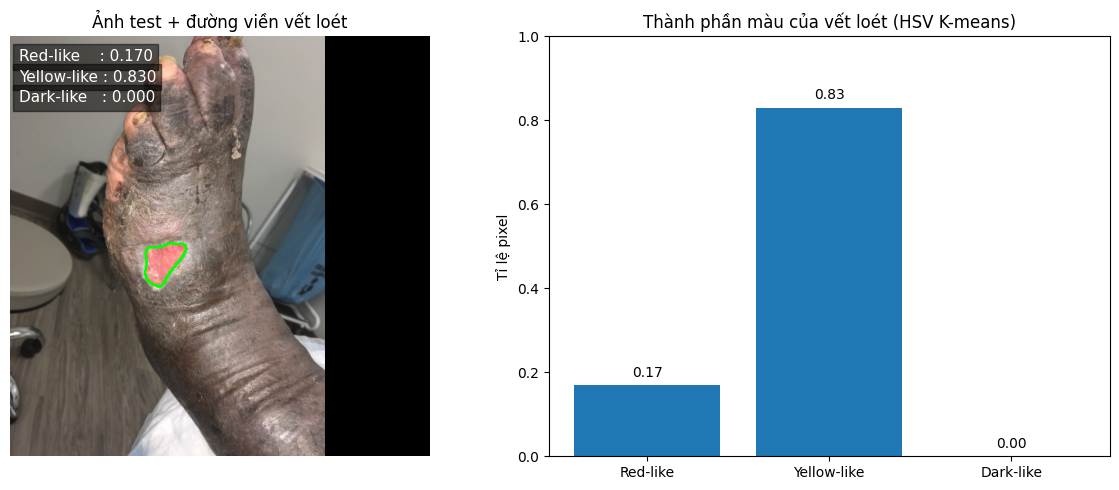

In [18]:
# Cell này cần các biến:
# - predicted_mask (từ Cell 10)  -> mask model segment, 0/1 hoặc 0..1
# - original_resized (từ Cell 10) -> ảnh RGB đã resize
# - kmeans_final (model KMeans K=3 đã train trên HSV pixel)
# - np, cv2, plt (đã import)

print("--- CELL DEMO: PHÂN TÍCH MÀU (1 ẢNH TEST) ---")

if 'predicted_mask' not in globals() or 'original_resized' not in globals():
    print("LỖI: Không tìm thấy 'predicted_mask' hoặc 'original_resized'.")
    print("Sếp chạy lại Cell 10 để load ảnh test + mask.")
elif 'kmeans_final' not in globals():
    print("LỖI: Không tìm thấy 'kmeans_final'. Nhớ chạy cell train K-means K=3 trước.")
else:
    # 1. Chuẩn bị mask (uint8, 0-255)
    # predicted_mask có thể là 0/1 float, nên mình threshold nhẹ cho chắc
    mask_bool = predicted_mask > 0.5
    mask_uint8 = (mask_bool.astype(np.uint8) * 255)

    if mask_bool.sum() == 0:
        print("LỖI: Mask không có pixel nào > 0, không phân tích màu được.")
    else:
        # 2. Lấy pixel vùng loét từ original_resized (giả định là RGB)
        ulcer_pixels = original_resized[mask_bool].astype(np.uint8)  # (N, 3)

        # 3. RGB -> HSV
        ulcer_reshaped = ulcer_pixels.reshape(-1, 1, 3)
        hsv = cv2.cvtColor(ulcer_reshaped, cv2.COLOR_RGB2HSV).reshape(-1, 3)

        # 4. Chuẩn hoá về [0,1]
        h = hsv[:, 0] / 179.0
        s = hsv[:, 1] / 255.0
        v = hsv[:, 2] / 255.0
        X = np.stack([h, s, v], axis=1)

        # 5. Ép kiểu cho khớp với KMeans
        X = X.astype(np.float64)
        kmeans_final.cluster_centers_ = kmeans_final.cluster_centers_.astype(np.float64)

        # 6. Dự đoán cụm màu
        labels = kmeans_final.predict(X)
        total = len(labels)

        # Mapping: 0 = red-like, 1 = yellow-like, 2 = dark-like
        pct_red   = np.sum(labels == 0) / total
        pct_yel   = np.sum(labels == 1) / total
        pct_dark  = np.sum(labels == 2) / total

        text_red  = f"Red-like    : {pct_red:.3f}"
        text_yel  = f"Yellow-like : {pct_yel:.3f}"
        text_dark = f"Dark-like   : {pct_dark:.3f}"

        print("--- BÁO CÁO MÀU (ẢNH TEST) ---")
        print(text_red)
        print(text_yel)
        print(text_dark)

        # 7. Vẽ overlay mask + info text (giống style Cell kích thước)
        overlay_display = original_resized.copy()
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            main_contour = max(contours, key=cv2.contourArea)
            cv2.drawContours(overlay_display, [main_contour], -1, (0, 255, 0), 2)  # viền xanh lá

        plt.figure(figsize=(12, 5))

        # 7.1 Ảnh + mask overlay + text
        plt.subplot(1, 2, 1)
        plt.imshow(overlay_display)
        plt.title("Ảnh test + đường viền vết loét")
        plt.axis("off")
        plt.text(10, 30, text_red,  color='white', fontsize=11,
                 bbox=dict(facecolor='black', alpha=0.5))
        plt.text(10, 55, text_yel,  color='white', fontsize=11,
                 bbox=dict(facecolor='black', alpha=0.5))
        plt.text(10, 80, text_dark, color='white', fontsize=11,
                 bbox=dict(facecolor='black', alpha=0.5))

        # 7.2 Biểu đồ cột % 3 màu
        plt.subplot(1, 2, 2)
        labels_bar = ["Red-like", "Yellow-like", "Dark-like"]
        values_bar = [pct_red, pct_yel, pct_dark]
        plt.bar(labels_bar, values_bar)
        plt.ylim(0, 1.0)
        plt.ylabel("Tỉ lệ pixel")
        plt.title("Thành phần màu của vết loét (HSV K-means)")
        for i, v in enumerate(values_bar):
            plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
        
        plt.tight_layout()
        plt.show()


In [20]:
# Nếu df_color_features vẫn còn trong RAM:
if 'df_color_features' in globals():
    # Đổi img_name -> image_name cho khớp với Bước 6
    df_color_features = df_color_features.rename(columns={"img_name": "image_name"})
    # Copy sang df_features_final để Bước 6 xài
    df_features_final = df_color_features.copy()
else:
    # Trường hợp mày đã lưu CSV rồi, chỉ còn file
    df_color_features = pd.read_csv("color_features_ulcer_red_yellow_dark.csv")
    df_color_features = df_color_features.rename(columns={"img_name": "image_name"})
    df_features_final = df_color_features.copy()

print("df_features_final ready, 5 dòng đầu:")
print(df_features_final.head())


df_features_final ready, 5 dòng đầu:
  image_name  pct_red_like  pct_yellow_like  pct_dark_like  num_pixels  split
0   0011.png      0.288486         0.161492       0.550022        9276  train
1   0012.png      0.048798         0.919883       0.031318        1373  train
2   0013.png      0.139273         0.808241       0.052486        4344  train
3   0014.png      0.001749         0.993529       0.004722        5718  train
4   0015.png      0.664269         0.000000       0.335731         417  train


In [21]:
# Cell này cần:
# - df_features_final (từ Cell 9, chứa % màu)
# - all_image_pairs (từ Cell 5, danh sách 1010 file)
# - CFG.IMG_SIZE (từ Cell 5)
# - np, cv2, tqdm, pd (đã import)

print("--- BƯỚC 6: Thêm Kích thước / Hình thái (Size/Morphology) ---")

# --- PHẦN 1: ĐỊNH NGHĨA HÀM ---
def analyze_morphology(mask_gt_uint8):
    """
    Tính toán diện tích, chu vi, độ tròn từ MASK THẬT (uint8, 0-255).
    """
    pixel_area = 0.0
    perimeter = 0.0
    circularity = 0.0

    # 1. Diện tích (tính bằng cách đếm pixel)
    pixel_area = np.sum(mask_gt_uint8 > 0)
    
    if pixel_area == 0:
        return 0.0, 0.0, 0.0 # Trả về 0 nếu mask rỗng

    # 2. Tìm contours
    contours, _ = cv2.findContours(mask_gt_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        main_contour = max(contours, key=cv2.contourArea)
        
        # 3. Chu vi
        perimeter = cv2.arcLength(main_contour, True)
        
        # 4. Độ tròn
        if perimeter > 0:
            circularity = (4 * np.pi * pixel_area) / (perimeter**2)
            
    return pixel_area, perimeter, circularity

print("✅ Đã nạp hàm 'analyze_morphology'.")

# --- PHẦN 2: CHẠY VÒNG LẶP (CHỈ TÍNH KÍCH THƯỚC) ---

# 1. Kiểm tra biến
if 'all_image_pairs' not in globals():
    print("LỖI: Không tìm thấy 'all_image_pairs'. Sếp chạy lại Cell 5.")
else:
    all_features_morphology = [] # Nơi lưu kết quả Kích thước
    
    for img_path, mask_path, split in tqdm(all_image_pairs, desc="Phân tích Kích thước (1010 ảnh)"):
        try:
            # 2a. Chỉ Load Mask (Label thật)
            mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if mask_gray is None:
                continue

            # 2b. Resize
            mask_resized = cv2.resize(mask_gray, (CFG.IMG_SIZE, CFG.IMG_SIZE), 
                                      interpolation=cv2.INTER_NEAREST)
            
            # 2c. Chuẩn hóa Mask về 0-255 (uint8)
            mask_gt_uint8 = (mask_resized > 0).astype(np.uint8) * 255
            
            # 2d. Gọi hàm
            area, peri, circ = analyze_morphology(mask_gt_uint8)
            
            # 2e. Lưu kết quả
            feature_dict = {
                "image_name": os.path.basename(img_path),
                "area_pixels": area,
                "perimeter": peri,
                "circularity": circ
            }
            all_features_morphology.append(feature_dict)
            
        except Exception as e:
            print(f"Lỗi khi xử lý file {img_path}: {e}")

    print(f"\n✅✅✅ Hoàn tất phân tích Kích thước!")

    # --- PHẦN 3: GHÉP (MERGE) VÀO DATAFRAME CHÍNH ---
    
    if 'df_features_final' not in globals():
        print("LỖI: Không tìm thấy 'df_features_final' (từ Cell 9).")
    else:
        # 1. Tạo DataFrame Kích thước
        df_morphology = pd.DataFrame(all_features_morphology)
        
        # 2. Ghép (Merge)
        print("Đang ghép (merge) DataFrame Kích thước vào DataFrame Màu sắc...")
        df_features_final = pd.merge(
            df_features_final,  # DataFrame từ Cell 9 (có % màu)
            df_morphology,      # DataFrame mới (có area, peri)
            on="image_name",    # Ghép bằng tên file
            how="left"          # Giữ tất cả dòng từ df_features_final
        )
        
        # 3. Lưu file CSV
        CSV_PATH_FINAL = "wound_features_dataset.csv" # Tên file từ Cell 9
        df_features_final.to_csv(CSV_PATH_FINAL, index=False)
        
        print(f"✅ Đã ghép và lưu file: {CSV_PATH_FINAL}")
        
        # 4. Hiển thị 5 dòng đầu (với các cột mới)
        print("\n--- 5 dòng đầu của DataFrame (Đã thêm Kích thước): ---")
        print(df_features_final.head())

--- BƯỚC 6: Thêm Kích thước / Hình thái (Size/Morphology) ---
✅ Đã nạp hàm 'analyze_morphology'.


Phân tích Kích thước (1010 ảnh): 100%|██████████| 1010/1010 [00:05<00:00, 188.51it/s]


✅✅✅ Hoàn tất phân tích Kích thước!
Đang ghép (merge) DataFrame Kích thước vào DataFrame Màu sắc...
✅ Đã ghép và lưu file: wound_features_dataset.csv

--- 5 dòng đầu của DataFrame (Đã thêm Kích thước): ---
  image_name  pct_red_like  pct_yellow_like  pct_dark_like  num_pixels  split  \
0   0011.png      0.288486         0.161492       0.550022        9276  train   
1   0012.png      0.048798         0.919883       0.031318        1373  train   
2   0013.png      0.139273         0.808241       0.052486        4344  train   
3   0014.png      0.001749         0.993529       0.004722        5718  train   
4   0015.png      0.664269         0.000000       0.335731         417  train   

   area_pixels   perimeter  circularity  
0       9276.0  489.462984     0.486554  
1       1373.0  228.166520     0.331418  
2       4344.0  290.936072     0.644918  
3       5718.0  517.404109     0.268407  
4        417.0   92.183766     0.616648  


In [1]:
# Cell này cần các biến:
# - predicted_mask (từ Cell 10)
# - original_resized (từ Cell 10)
# - Hàm analyze_morphology (từ Cell 11)
# - np, cv2, plt (đã import)

print("--- CELL 12: DEMO KÍCH THƯỚC / HÌNH THÁI (1 ẢNH TEST) ---")

# 1. Kiểm tra biến
if 'predicted_mask' not in globals() or 'original_resized' not in globals():
    print("LỖI: Không tìm thấy 'predicted_mask' hoặc 'original_resized'.")
    print("Sếp vui lòng chạy lại Cell 10 để load ảnh test.")
elif 'analyze_morphology' not in globals():
    print("LỖI: Không tìm thấy hàm 'analyze_morphology'. Sếp chạy lại Cell 11.")
else:
    # 2. Chuẩn bị mask (uint8, 0-255)
    mask_uint8 = (predicted_mask * 255).astype(np.uint8)
    
    # 3. Tính toán
    area, peri, circ = analyze_morphology(mask_uint8)
    
    # 4. Tạo ảnh Overlay
    overlay_display = original_resized.copy()
    
    # Tìm và vẽ contour
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        main_contour = max(contours, key=cv2.contourArea)
        # Vẽ viền contour (màu xanh lá, dày 2px)
        cv2.drawContours(overlay_display, [main_contour], -1, (0, 255, 0), 2)
    
    # 5. Tạo text để in lên ảnh
    text_area = f"Dien tich (Area): {area:.0f} pixels"
    text_peri = f"Chu vi (Perimeter): {peri:.2f} pixels"
    text_circ = f"Do tron (Circularity): {circ:.4f}"
    
    print("--- BÁO CÁO KÍCH THƯỚC (ẢNH TEST) ---")
    print(text_area)
    print(text_peri)
    print(text_circ)

    # 6. Vẽ plot
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay_display)
    
    # Đặt tiêu đề
    plt.title("Phan tich Kich thuoc / Hinh thai")
    
    # In 3 dòng text lên ảnh
    # (x=10, y=30) là tọa độ (pixel)
    plt.text(10, 30, text_area, color='white', fontsize=12, 
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(10, 60, text_peri, color='white', fontsize=12, 
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(10, 90, text_circ, color='white', fontsize=12, 
             bbox=dict(facecolor='black', alpha=0.5))
    
    plt.axis("off")
    plt.show()

--- CELL 12: DEMO KÍCH THƯỚC / HÌNH THÁI (1 ẢNH TEST) ---
LỖI: Không tìm thấy 'predicted_mask' hoặc 'original_resized'.
Sếp vui lòng chạy lại Cell 10 để load ảnh test.


--- CELL 13 (Update 3 - FIX LỖI): DEMO GỒ GHỀ ---
✅ Đã định nghĩa lại hàm 'analyze_texture'.
--- BÁO CÁO GỒ GHỀ (ẢNH TEST) ---
Contrast (Tuong phan): 1735.7867
Homogeneity (Dong nhat): 0.1534


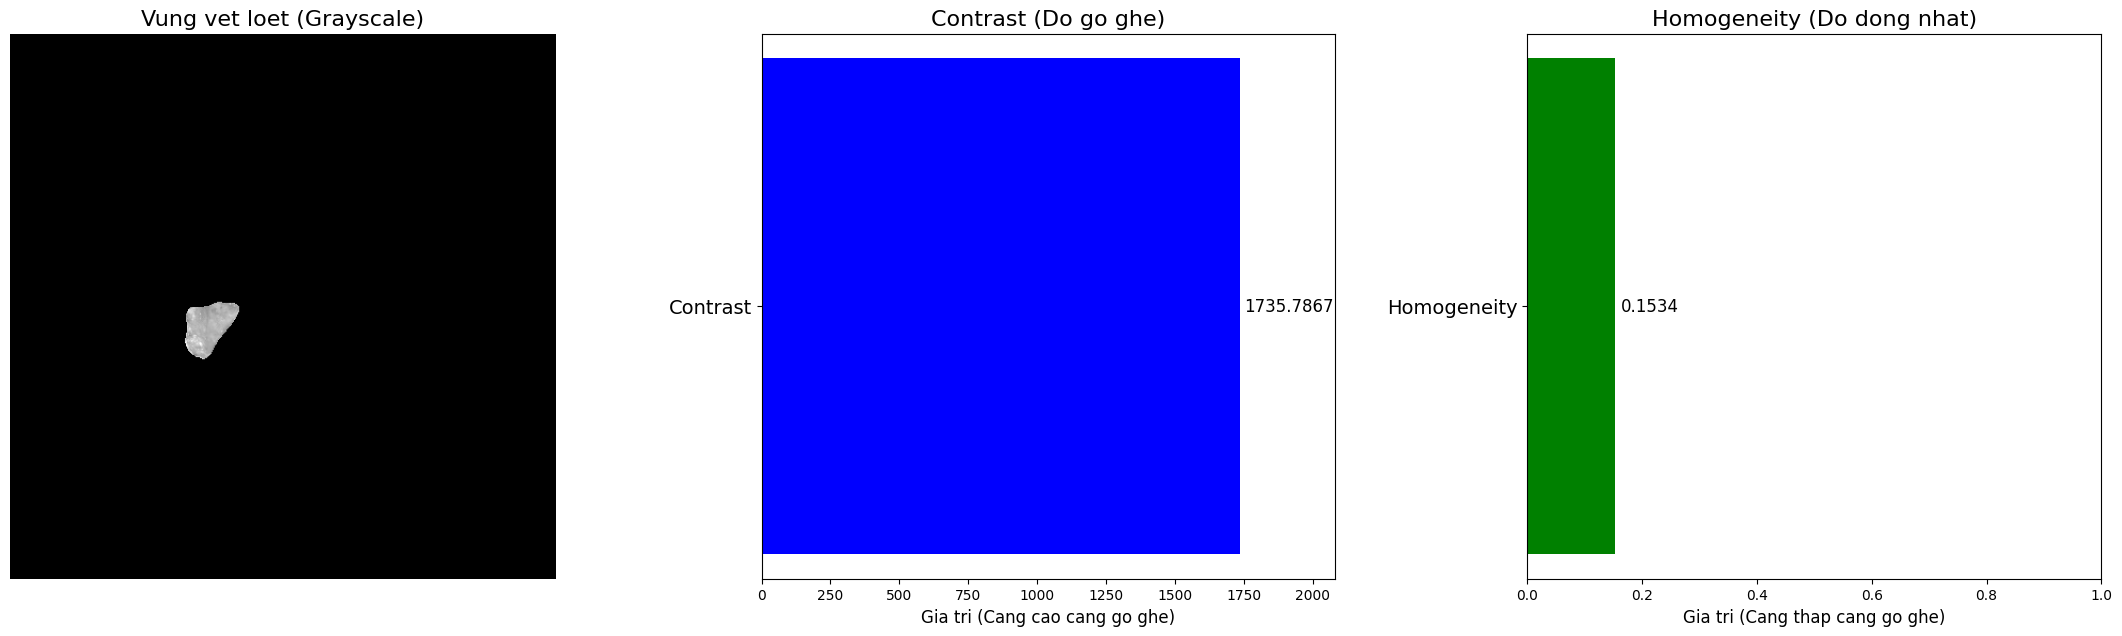

In [23]:
# Cell này cần các biến:
# - predicted_mask (từ Cell 10)
# - original_resized (từ Cell 10)
# - thư viện: numpy, cv2, matplotlib, skimage

import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops

print("--- CELL 13 (Update 3 - FIX LỖI): DEMO GỒ GHỀ ---")

# --- 1. ĐỊNH NGHĨA HÀM ANALYZE_TEXTURE TẠI CHỖ (CHO CHẮC ĂN) ---
def analyze_texture(image_rgb, mask_gt_uint8):
    """
    Tính GLCM (Contrast, Homogeneity) từ MASK (uint8, 0-255).
    """
    if np.sum(mask_gt_uint8) == 0:
        return 0.0, 0.0, 0.0, 0.0 # Mask rỗng

    # Chuyển sang ảnh xám
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    
    try:
        # Tìm bounding box để cắt ROI (tối ưu tốc độ)
        rows = np.any(mask_gt_uint8, axis=1)
        cols = np.any(mask_gt_uint8, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        
        # Cắt ROI (Vùng ảnh xám)
        roi_gray = gray_image[rmin:rmax+1, cmin:cmax+1]
        roi_mask = mask_gt_uint8[rmin:rmax+1, cmin:cmax+1]
        
        # Gán 0 cho vùng nền (để GLCM bỏ qua)
        roi_gray[roi_mask == 0] = 0
        
        # Tính GLCM
        glcm = graycomatrix(roi_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        glcm[0,0,:,:] = 0 # Bỏ qua cặp (0,0) (nền-nền)
        
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        
        return contrast, homogeneity, energy, correlation
    except Exception as e:
        print(f"Lỗi tính GLCM: {e}")
        return 0.0, 0.0, 0.0, 0.0

print("✅ Đã định nghĩa lại hàm 'analyze_texture'.")


# --- 2. CHẠY TÍNH TOÁN VÀ VẼ ---
if 'predicted_mask' not in globals() or 'original_resized' not in globals():
    print("LỖI: Sếp chạy lại Cell 10 để load ảnh test trước nhé.")
else:
    # Chuẩn bị mask
    mask_uint8 = (predicted_mask * 255).astype(np.uint8)
    
    # Tính toán
    con, homo, ener, corr = analyze_texture(original_resized, mask_uint8)
    
    print("--- BÁO CÁO GỒ GHỀ (ẢNH TEST) ---")
    print(f"Contrast (Tuong phan): {con:.4f}")
    print(f"Homogeneity (Dong nhat): {homo:.4f}")

    # Lấy ảnh Grayscale ROI để show
    gray_image_resized = cv2.cvtColor(original_resized, cv2.COLOR_RGB2GRAY)
    roi_display = np.zeros_like(gray_image_resized)
    roi_display[mask_uint8 > 0] = gray_image_resized[mask_uint8 > 0]

    # --- VẼ PLOT (TÁCH LÀM 3 CỘT) ---
    fig, ax = plt.subplots(1, 3, figsize=(22, 7))
    
    # Plot 1: Ảnh xám
    ax[0].imshow(roi_display, cmap='gray')
    ax[0].set_title("Vung vet loet (Grayscale)", fontsize=16)
    ax[0].axis("off")

    # Plot 2: Contrast
    bars_con = ax[1].barh(['Contrast'], [con], color='blue')
    ax[1].set_title("Contrast (Do go ghe)", fontsize=16)
    ax[1].set_xlabel("Gia tri (Cang cao cang go ghe)", fontsize=12)
    ax[1].tick_params(axis='y', labelsize=14)
    ax[1].set_xlim(0, con * 1.2) # Scale
    ax[1].text(con + (con * 0.01), 0, f"{con:.4f}", va='center', fontsize=12)

    # Plot 3: Homogeneity
    bars_homo = ax[2].barh(['Homogeneity'], [homo], color='green')
    ax[2].set_title("Homogeneity (Do dong nhat)", fontsize=16)
    ax[2].set_xlabel("Gia tri (Cang thap cang go ghe)", fontsize=12)
    ax[2].tick_params(axis='y', labelsize=14)
    ax[2].set_xlim(0, 1.0) # Scale 0-1
    ax[2].text(homo + 0.01, 0, f"{homo:.4f}", va='center', fontsize=12)

    plt.tight_layout(pad=3.0)
    plt.show()

--- CELL 14: DEMO PHÂN TÍCH VÙNG DA XUNG QUANH (PERIWOUND) ---
✅ Đã nạp hàm 'analyze_color'.
--- BÁO CÁO VÙNG DA XUNG QUANH ---
L* (Do sang): 157.93
a* (Do do/luc): 133.95 (Cang duong -> cang do -> viem)
b* (Do vang/xanh): 135.47 (Cang duong -> cang vang)


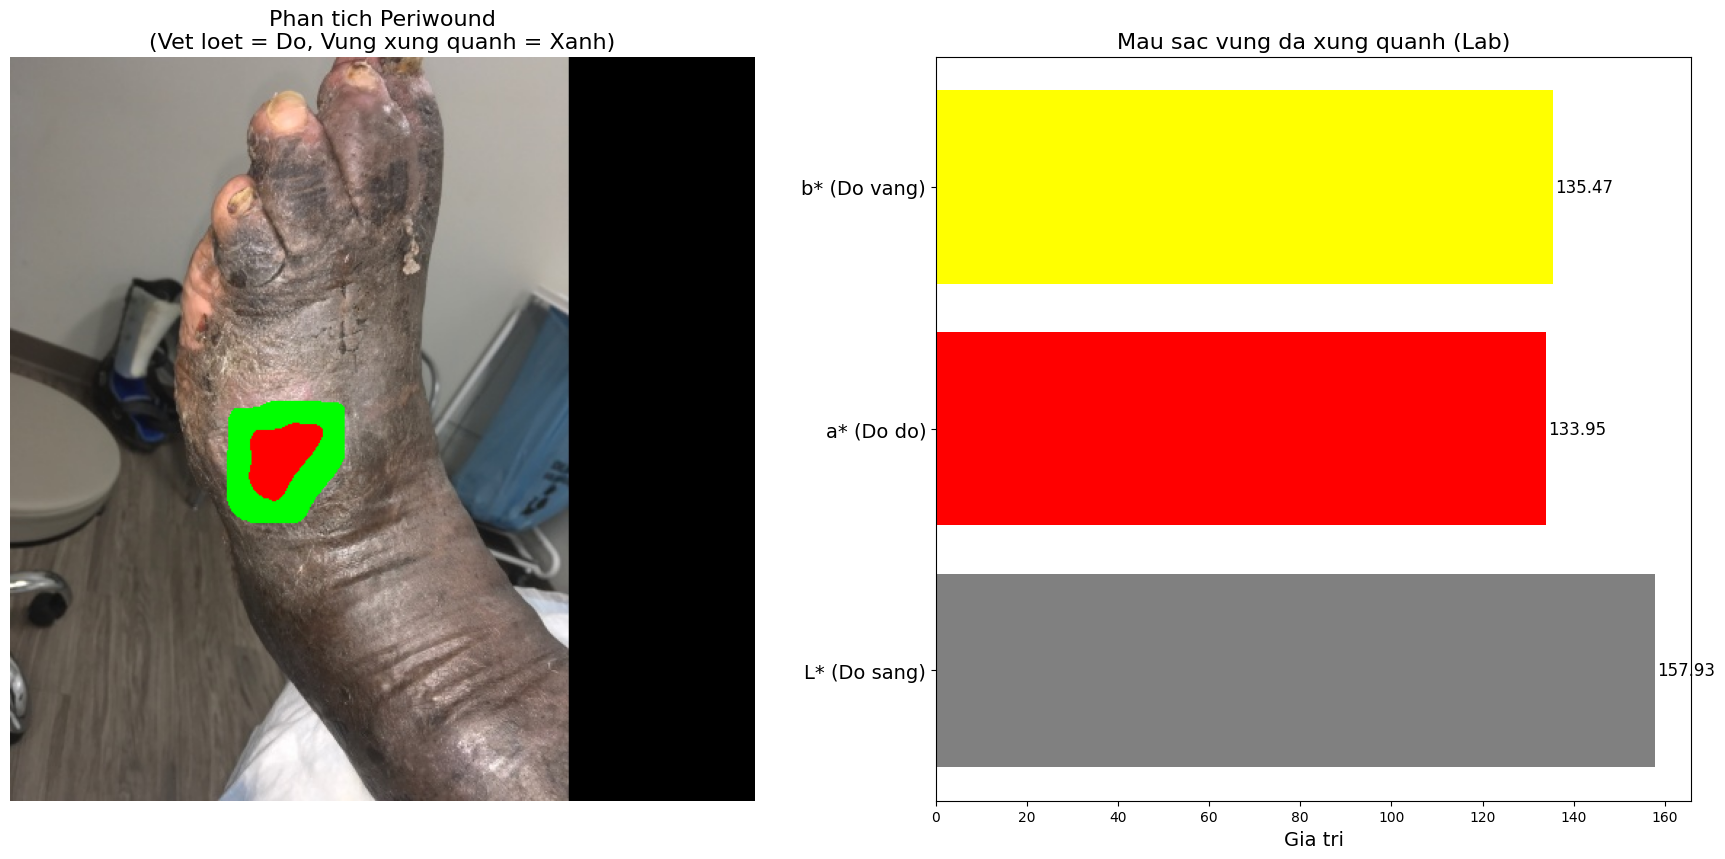

In [24]:
# Cell này cần các biến:
# - predicted_mask (từ Cell 10)
# - original_resized (từ Cell 10)
# - Cần hàm analyze_color (đã định nghĩa ở Cell 4 của flow CSV)
# - np, cv2, plt (đã import)

print("--- CELL 14: DEMO PHÂN TÍCH VÙNG DA XUNG QUANH (PERIWOUND) ---")

# --- PHẦN 1: ĐỊNH NGHĨA HÀM (Cho chắc) ---

# (Hàm này đã được định nghĩa ở Cell 4 của flow CSV,
# nhưng ta định nghĩa lại cho chắc)
def analyze_color(image_rgb, mask_uint8):
    mask_bool = mask_uint8.astype(bool)
    if np.sum(mask_bool) == 0:
        return (0,0,0), (0,0,0), (0,0,0)
    
    # Lab (Quan trọng nhất)
    try:
        lab_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)
        pixels_lab = lab_image[mask_bool]
        mean_lab = np.mean(pixels_lab, axis=0)
    except Exception:
        mean_lab = (0,0,0)
    
    # RGB
    try:
        pixels_rgb = image_rgb[mask_bool]
        mean_rgb = np.mean(pixels_rgb, axis=0)
    except Exception:
        mean_rgb = (0,0,0)

    # HSV
    try:
        hsv_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
        pixels_hsv = hsv_image[mask_bool]
        mean_hsv = np.mean(pixels_hsv, axis=0)
    except Exception:
        mean_hsv = (0,0,0)
        
    return mean_rgb, mean_hsv, mean_lab

print("✅ Đã nạp hàm 'analyze_color'.")


# --- PHẦN 2: CHẠY DEMO ---

if 'predicted_mask' not in globals() or 'original_resized' not in globals():
    print("LỖI: Chạy lại Cell 10 để load ảnh test.")
else:
    # 1. Chuẩn bị mask (uint8, 0-255)
    mask_uint8 = (predicted_mask * 255).astype(np.uint8)
    
    # 2. Tạo "vòng" (ring)
    PERIWOUND_WIDTH = 15 # Sếp có thể chỉnh độ rộng (15 pixels)
    kernel_size = (PERIWOUND_WIDTH * 2) + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # 2a. Thổi phồng (Dilate)
    dilated_mask = cv2.dilate(mask_uint8, kernel, iterations=1)
    
    # 2b. Trừ đi -> Lấy cái "vòng"
    periwound_mask = cv2.subtract(dilated_mask, mask_uint8)
    
    # 3. Phân tích màu sắc trên "vòng"
    (r,g,b), (h,s,v), (l,a,b) = analyze_color(original_resized, periwound_mask)
    
    print("--- BÁO CÁO VÙNG DA XUNG QUANH ---")
    print(f"L* (Do sang): {l:.2f}")
    print(f"a* (Do do/luc): {a:.2f} (Cang duong -> cang do -> viem)")
    print(f"b* (Do vang/xanh): {b:.2f} (Cang duong -> cang vang)")

    # 4. Tạo ảnh Overlay (vẽ cái vòng)
    overlay_display = original_resized.copy()
    # Vẽ mask vết loét (màu đỏ)
    overlay_display[predicted_mask > 0] = (255, 0, 0)
    # Vẽ "vòng" periwound (màu xanh lá)
    overlay_display[periwound_mask > 0] = (0, 255, 0)


    # --- PHẦN 3: VẼ PLOT ---
    fig, ax = plt.subplots(1, 2, figsize=(18, 9))
    
    # Plot 1: Ảnh Overlay
    ax[0].imshow(overlay_display)
    ax[0].set_title("Phan tich Periwound\n(Vet loet = Do, Vung xung quanh = Xanh)", fontsize=16)
    ax[0].axis("off")
    
    # Plot 2: Biểu đồ cột cho Lab (quan trọng nhất)
    features = ['L* (Do sang)', 'a* (Do do)', 'b* (Do vang)']
    values = [l, a, b]
    colors = ['gray', 'red', 'yellow']
    
    bars = ax[1].barh(features, values, color=colors)
    ax[1].set_title("Mau sac vung da xung quanh (Lab)", fontsize=16)
    ax[1].set_xlabel("Gia tri", fontsize=14)
    ax[1].tick_params(axis='y', labelsize=14)
    
    # Thêm text giá trị
    for bar in bars:
        width = bar.get_width()
        ax[1].text(width + 0.5, # Vị trí text
                   bar.get_y() + bar.get_height()/2,
                   f"{width:.2f}",
                   va='center', fontsize=12)

    plt.tight_layout(pad=3.0)
    plt.show()

In [25]:
# Cell 12: Thêm Gồ ghề (Texture) và Vùng da xung quanh (Periwound) vào CSV

# Cell này cần:
# - df_features_final (từ Cell 11, hoặc load từ file CSV)
# - all_image_pairs (từ Cell 5)
# - CFG.IMG_SIZE, CFG.DEVICE
# - thư viện: np, cv2, tqdm, pd, graycomatrix, graycoprops

print("--- BƯỚC 7: Thêm Gồ ghề (Texture) & Vùng da xung quanh (Periwound) ---")

# --- PHẦN 1: ĐỊNH NGHĨA HÀM ---

# 1. Hàm Texture (GLCM)
def analyze_texture(image_rgb, mask_gt_uint8):
    if np.sum(mask_gt_uint8) == 0:
        return 0.0, 0.0, 0.0, 0.0
    
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    
    try:
        # Tìm bounding box để cắt ROI (cho nhanh)
        rows = np.any(mask_gt_uint8, axis=1)
        cols = np.any(mask_gt_uint8, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        
        roi_gray = gray_image[rmin:rmax+1, cmin:cmax+1]
        roi_mask = mask_gt_uint8[rmin:rmax+1, cmin:cmax+1]
        
        # Gán nền = 0
        roi_gray[roi_mask == 0] = 0
        
        # Tính GLCM
        glcm = graycomatrix(roi_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        glcm[0,0,:,:] = 0 # Bỏ qua cặp (0,0)
        
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        
        return contrast, homogeneity, energy, correlation
    except Exception:
        return 0.0, 0.0, 0.0, 0.0

# 2. Hàm Periwound (Vùng da xung quanh)
def analyze_periwound(image_rgb, mask_gt_uint8, width=15):
    # Tạo kernel
    kernel_size = (width * 2) + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Thổi phồng
    dilated_mask = cv2.dilate(mask_gt_uint8, kernel, iterations=1)
    
    # Trừ đi -> Vòng
    periwound_mask = cv2.subtract(dilated_mask, mask_gt_uint8)
    
    # Tính màu trung bình (Lab)
    mask_bool = periwound_mask.astype(bool)
    if np.sum(mask_bool) == 0:
        return 0.0, 0.0, 0.0 # Không có vùng xung quanh (mask chạm viền?)
        
    lab_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)
    pixels_lab = lab_image[mask_bool]
    mean_lab = np.mean(pixels_lab, axis=0)
    
    return mean_lab[0], mean_lab[1], mean_lab[2] # L, a, b

print("✅ Đã nạp hàm 'analyze_texture' và 'analyze_periwound'.")


# --- PHẦN 2: CHẠY VÒNG LẶP ---

# 1. Kiểm tra biến
if 'all_image_pairs' not in globals():
    print("LỖI: Không tìm thấy 'all_image_pairs'. Sếp chạy lại Cell 5.")
else:
    all_features_extra = []
    PERIWOUND_WIDTH = 15 # Độ rộng
    
    for img_path, mask_path, split in tqdm(all_image_pairs, desc="Phân tích Texture & Periwound"):
        try:
            # Load Ảnh + Mask
            image_bgr = cv2.imread(img_path)
            mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if image_bgr is None or mask_gray is None:
                continue
                
            # Resize
            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            image_resized = cv2.resize(image_rgb, (CFG.IMG_SIZE, CFG.IMG_SIZE), interpolation=cv2.INTER_LANCZOS4)
            mask_resized = cv2.resize(mask_gray, (CFG.IMG_SIZE, CFG.IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask_gt_uint8 = (mask_resized > 0).astype(np.uint8) * 255
            
            # 1. Tính Texture
            con, homo, ener, corr = analyze_texture(image_resized, mask_gt_uint8)
            
            # 2. Tính Periwound
            peri_l, peri_a, peri_b = analyze_periwound(image_resized, mask_gt_uint8, width=PERIWOUND_WIDTH)
            
            # Lưu
            feature_dict = {
                "image_name": os.path.basename(img_path),
                "texture_contrast": con,
                "texture_homogeneity": homo,
                "texture_energy": ener,
                "texture_correlation": corr,
                "periwound_L": peri_l,
                "periwound_a": peri_a, # Quan trọng: Độ đỏ
                "periwound_b": peri_b
            }
            all_features_extra.append(feature_dict)
            
        except Exception as e:
            print(f"Lỗi: {e}")

    print(f"\n✅✅✅ Hoàn tất! Đã trích xuất thêm features.")

    # --- PHẦN 3: GHÉP VÀ LƯU FINAL CSV ---
    
    # Load lại file CSV hiện tại (nếu df_features_final không có sẵn)
    CSV_PATH_FINAL = "wound_features_dataset.csv"
    if 'df_features_final' not in globals():
        if os.path.exists(CSV_PATH_FINAL):
            df_features_final = pd.read_csv(CSV_PATH_FINAL)
        else:
            print("LỖI: Không tìm thấy file CSV cũ.")
            
    if 'df_features_final' in globals():
        # Tạo DataFrame mới
        df_extra = pd.DataFrame(all_features_extra)
        
        # Ghép
        print("Đang ghép (merge) các features cuối cùng...")
        df_features_complete = pd.merge(
            df_features_final,
            df_extra,
            on="image_name",
            how="left"
        )
        
        # Lưu Final
        df_features_complete.to_csv(CSV_PATH_FINAL, index=False)
        print(f"✅✅✅ XONG! File CSV hoàn chỉnh đã được lưu: {CSV_PATH_FINAL}")
        
        print("\n--- 5 dòng đầu của DATASET HOÀN CHỈNH: ---")
        print(df_features_complete.head())
        df_features_complete.info()

--- BƯỚC 7: Thêm Gồ ghề (Texture) & Vùng da xung quanh (Periwound) ---
✅ Đã nạp hàm 'analyze_texture' và 'analyze_periwound'.


Phân tích Texture & Periwound: 100%|██████████| 1010/1010 [00:20<00:00, 50.17it/s]



✅✅✅ Hoàn tất! Đã trích xuất thêm features.
Đang ghép (merge) các features cuối cùng...
✅✅✅ XONG! File CSV hoàn chỉnh đã được lưu: wound_features_dataset.csv

--- 5 dòng đầu của DATASET HOÀN CHỈNH: ---
  image_name  pct_red_like  pct_yellow_like  pct_dark_like  num_pixels  split  \
0   0011.png      0.288486         0.161492       0.550022        9276  train   
1   0012.png      0.048798         0.919883       0.031318        1373  train   
2   0013.png      0.139273         0.808241       0.052486        4344  train   
3   0014.png      0.001749         0.993529       0.004722        5718  train   
4   0015.png      0.664269         0.000000       0.335731         417  train   

   area_pixels   perimeter  circularity  texture_contrast  \
0       9276.0  489.462984     0.486554        169.059104   
1       1373.0  228.166520     0.331418       3418.518469   
2       4344.0  290.936072     0.644918        588.492419   
3       5718.0  517.404109     0.268407       1065.277301   
4     

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


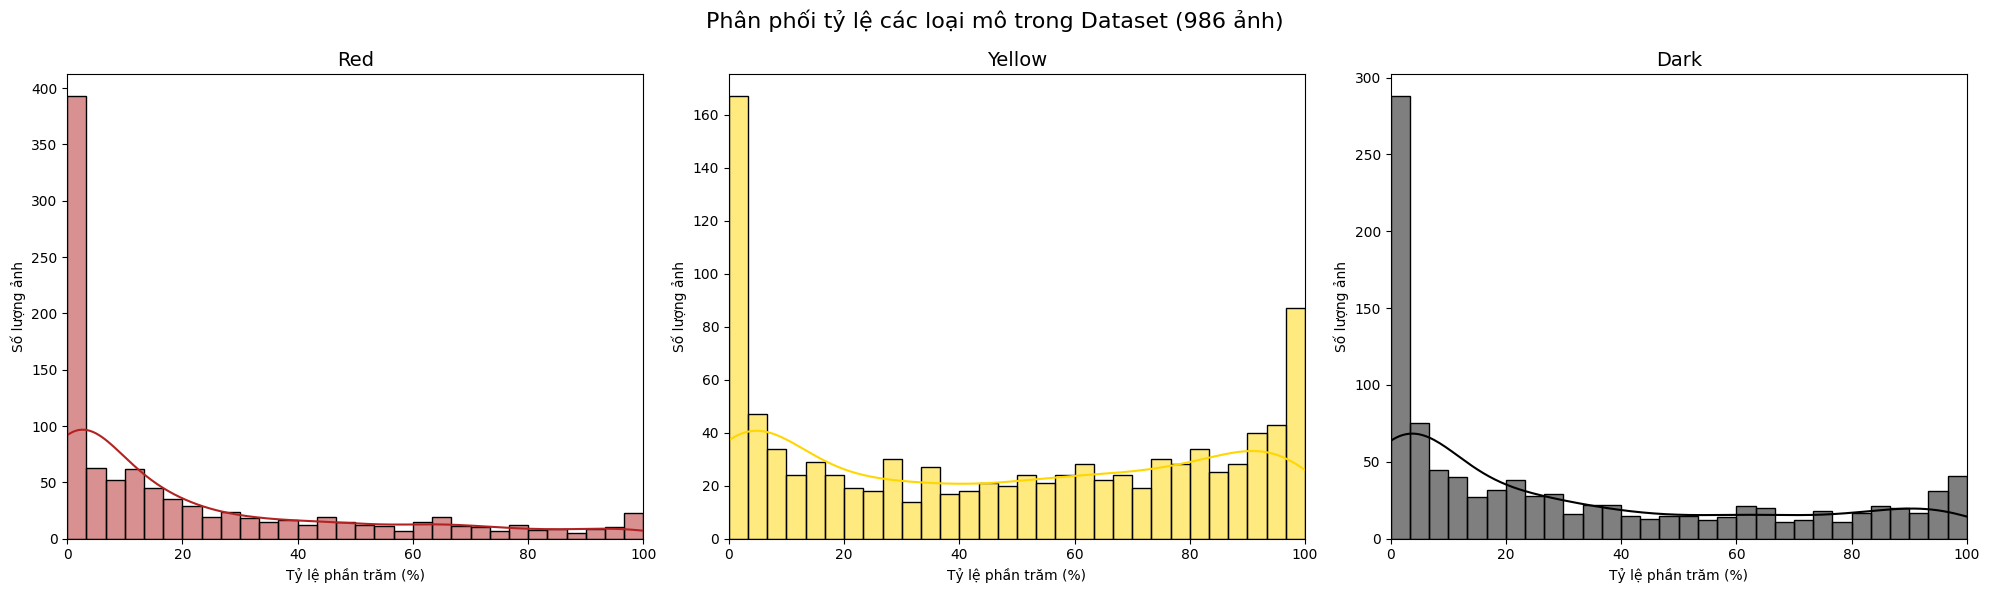

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("wound_features_dataset.csv")

colors = ['firebrick', 'gold', 'black']
cols   = ['pct_red_like', 'pct_yellow_like', 'pct_dark_like']
titles = ['Red', 'Yellow', 'Dark']

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(3):
    values_pct = df[cols[i]] * 100   # ⚡ nhân 100 để thành %
    sns.histplot(values_pct, kde=True, ax=ax[i],
                 color=colors[i], bins=30)
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].set_xlabel("Tỷ lệ phần trăm (%)")
    ax[i].set_ylabel("Số lượng ảnh")
    ax[i].set_xlim(0, 100)          # giờ mới hợp lý

plt.suptitle("Phân phối tỷ lệ các loại mô trong Dataset (986 ảnh)", fontsize=16)
plt.tight_layout()
plt.show()


--- 3. MA TRẬN TƯƠNG QUAN (CORRELATION HEATMAP) ---


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


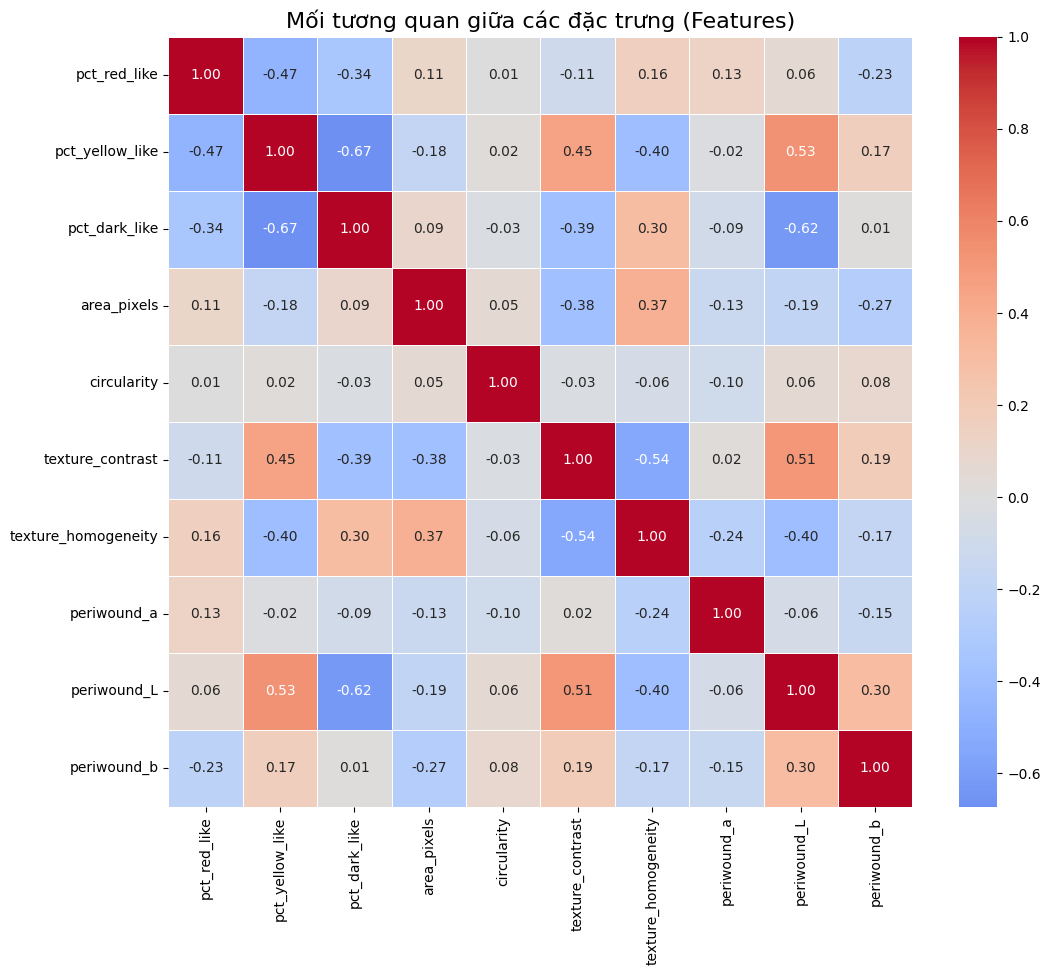

In [30]:
print("--- 3. MA TRẬN TƯƠNG QUAN (CORRELATION HEATMAP) ---")

# Chọn các cột quan trọng để soi
cols_to_analyze = [
    'pct_red_like', 'pct_yellow_like', 'pct_dark_like', # Màu vết loét
    'area_pixels', 'circularity',                    # Hình thái
    'texture_contrast', 'texture_homogeneity',       # Gồ ghề
    'periwound_a', 'periwound_L', 'periwound_b'                     # Da xung quanh
]

# Tính ma trận tương quan
corr_matrix = df[cols_to_analyze].corr()

# Vẽ Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Mối tương quan giữa các đặc trưng (Features)", fontsize=16)
plt.show()

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import f_classif

sns.set(style="whitegrid", font_scale=1.0)

# 1. Load data
df = pd.read_csv("/kaggle/input/additional/wound_features_dataset (1).csv")

# 2. Chọn các cột feature để phân tích (bỏ image_name, split,…)
feature_cols = [
    "pct_red_like",
    "pct_yellow_like",
    "pct_dark_like",
    "area_pixels",
    "perimeter",
    "circularity",
    "texture_contrast",
    "texture_homogeneity",
    "texture_energy",
    "texture_correlation",
    "periwound_L",
    "periwound_a",
    "periwound_b"
]

X = df[feature_cols].copy()

print("Shape feature matrix:", X.shape)


Shape feature matrix: (986, 13)


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


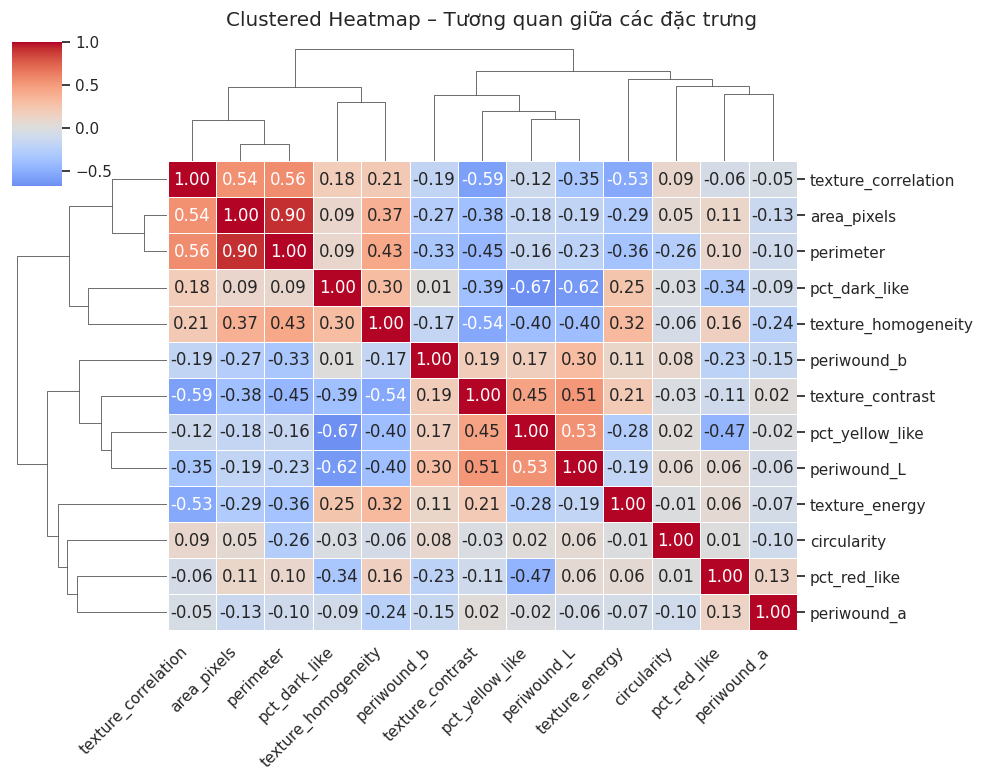

In [35]:
# === CLUSTERED HEATMAP CỦA MA TRẬN TƯƠNG QUAN ===

corr = X.corr()

g = sns.clustermap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    figsize=(10, 8)
)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right")
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
g.fig.suptitle("Clustered Heatmap – Tương quan giữa các đặc trưng", y=1.02)
plt.show()


Explained variance ratio: [0.29961957 0.17607043 0.11868667]

=== PCA LOADINGS ===
                          PC1       PC2       PC3
pct_red_like         0.077876  0.017925  0.700692
pct_yellow_like     -0.307425 -0.385939 -0.219569
pct_dark_like        0.263190  0.397436 -0.353590
area_pixels          0.358688 -0.303158  0.022177
perimeter            0.381417 -0.320886  0.063085
circularity         -0.037080 -0.003607 -0.157457
texture_contrast    -0.401817 -0.009788  0.072614
texture_homogeneity  0.333704  0.184672  0.064403
texture_energy      -0.067623  0.535061  0.115641
texture_correlation  0.341005 -0.295834 -0.222292
periwound_L         -0.340375 -0.284077  0.106371
periwound_a         -0.046931 -0.015804  0.303736
periwound_b         -0.207158  0.094508 -0.361597


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


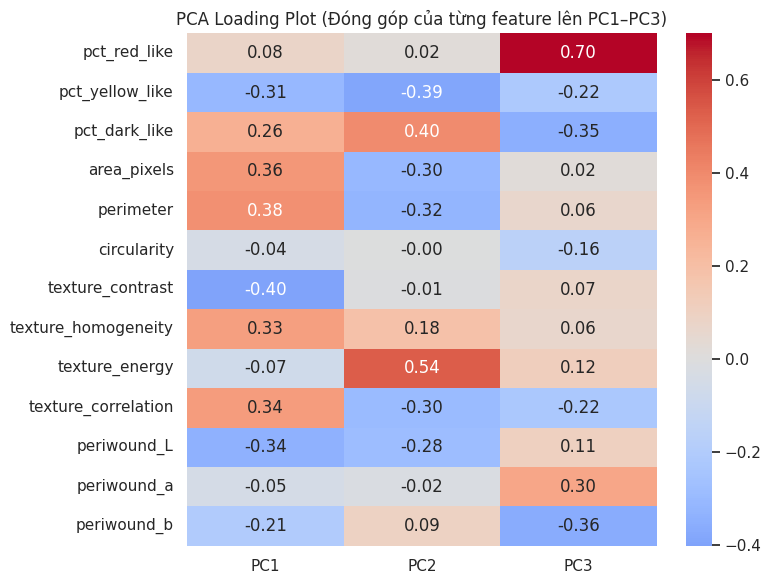

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load lại dataset
df = pd.read_csv("/kaggle/input/additional/wound_features_dataset (1).csv")

# 2. Chọn các feature numerical
feature_cols = [
    "pct_red_like", "pct_yellow_like", "pct_dark_like",
    "area_pixels", "perimeter", "circularity",
    "texture_contrast", "texture_homogeneity",
    "texture_energy", "texture_correlation",
    "periwound_L", "periwound_a", "periwound_b"
]

X = df[feature_cols].copy()

# 3. Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. PCA 3 components
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# 5. PCA loadings (đóng góp của từng feature lên từng PC)
loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=['PC1', 'PC2', 'PC3']
)

print("\n=== PCA LOADINGS ===")
print(loadings)

# 6. Vẽ heatmap loadings
plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, fmt=".2f",
            cmap="coolwarm", center=0)
plt.title("PCA Loading Plot (Đóng góp của từng feature lên PC1–PC3)")
plt.tight_layout()
plt.show()


K=2: inertia=10292.54, silhouette=0.1971
K=3: inertia=9106.29, silhouette=0.1921
K=4: inertia=8232.76, silhouette=0.1630
K=5: inertia=7457.39, silhouette=0.1783
K=6: inertia=6998.85, silhouette=0.1605
K=7: inertia=6570.59, silhouette=0.1737
K=8: inertia=6185.57, silhouette=0.1719
K=9: inertia=5863.59, silhouette=0.1577
K=10: inertia=5601.99, silhouette=0.1635


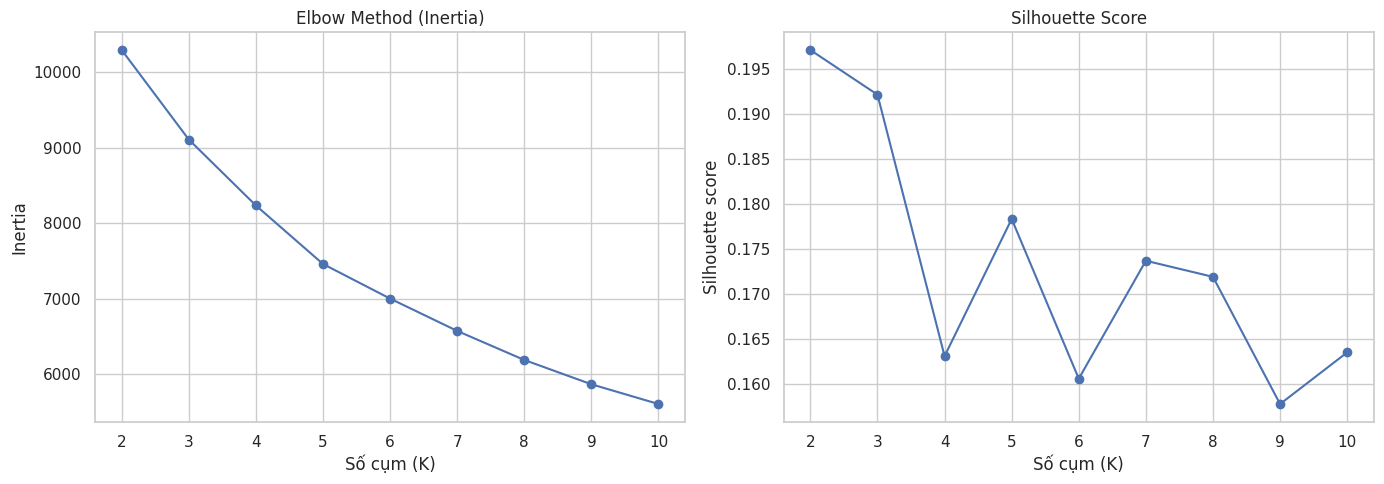

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv("/kaggle/input/additional/wound_features_dataset (1).csv")

# 2. Chọn toàn bộ các feature numeric
feature_cols = [
    "pct_red_like", "pct_yellow_like", "pct_dark_like",
    "area_pixels", "perimeter", "circularity",
    "texture_contrast", "texture_homogeneity",
    "texture_energy", "texture_correlation",
    "periwound_L", "periwound_a", "periwound_b"
]

X = df[feature_cols].copy()

# 3. Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Chạy K = 2..10
K_list = list(range(2, 11))
inertias = []
sil_scores = []

for K in K_list:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

    print(f"K={K}: inertia={kmeans.inertia_:.2f}, silhouette={sil:.4f}")

# 5. Vẽ biểu đồ Elbow + Silhouette
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
ax[0].plot(K_list, inertias, marker='o')
ax[0].set_title("Elbow Method (Inertia)")
ax[0].set_xlabel("Số cụm (K)")
ax[0].set_ylabel("Inertia")

# Silhouette
ax[1].plot(K_list, sil_scores, marker='o')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Số cụm (K)")
ax[1].set_ylabel("Silhouette score")

plt.tight_layout()
plt.show()


In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Load file
df = pd.read_csv("/kaggle/input/additional/wound_features_dataset (1).csv")

# Chọn feature numeric
feature_cols = [
    "pct_red_like", "pct_yellow_like", "pct_dark_like",
    "area_pixels", "perimeter", "circularity",
    "texture_contrast", "texture_homogeneity",
    "texture_energy", "texture_correlation",
    "periwound_L", "periwound_a", "periwound_b"
]

X = df[feature_cols].copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
#   KMEANS K = 3
# ==========================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df["cluster_raw"] = clusters

# ==========================
#   ĐỔI TÊN CLUSTER
#   (dựa trên centroid severity)
# ==========================
cent = pd.DataFrame(kmeans.cluster_centers_, columns=feature_cols)

# Severity score = weight color + size + texture
severity_score = (
    cent["pct_dark_like"]*2 +
    cent["pct_yellow_like"]*1.5 +
    cent["area_pixels"]*1.4 +
    cent["texture_contrast"]*1.2 -
    cent["pct_red_like"]*1.3 +
    -cent["periwound_L"]*0.7
)

order = np.argsort(severity_score)  # nhỏ nhất → lớn nhất = low → high

mapping = {
    order[0]: "low",
    order[1]: "medium",
    order[2]: "high"
}

df["risk_level"] = df["cluster_raw"].map(mapping)

print("Mapping severity:", mapping)
print(df[["image_name", "risk_level"]].head())


Mapping severity: {2: 'low', 0: 'medium', 1: 'high'}
  image_name risk_level
0   0011.png     medium
1   0012.png        low
2   0013.png     medium
3   0014.png     medium
4   0015.png       high


Explained variance: [0.29961957 0.17607043]


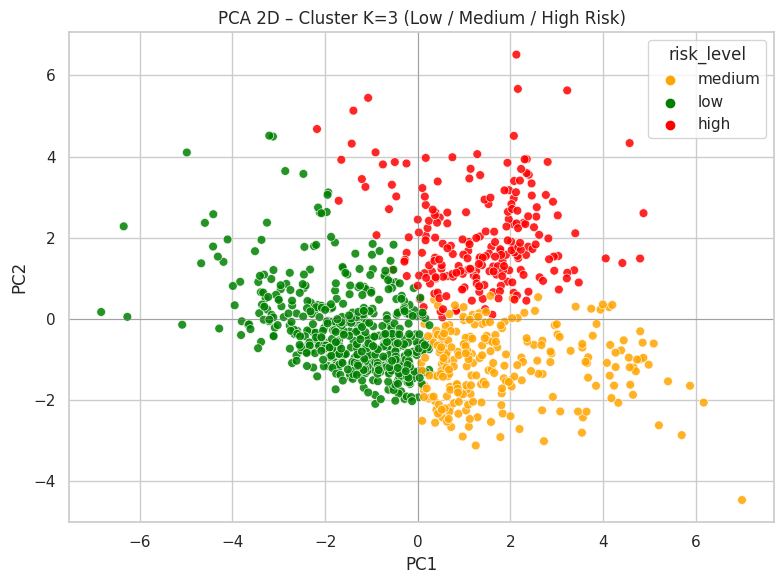

In [41]:
# PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:,0]
df["PC2"] = X_pca[:,1]

print("Explained variance:", pca.explained_variance_ratio_)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="PC1",
    y="PC2",
    hue="risk_level",
    palette={"low":"green", "medium":"orange", "high":"red"},
    s=40,
    alpha=0.85
)
plt.title("PCA 2D – Cluster K=3 (Low / Medium / High Risk)")
plt.axhline(0, color="grey", linewidth=0.4)
plt.axvline(0, color="grey", linewidth=0.4)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


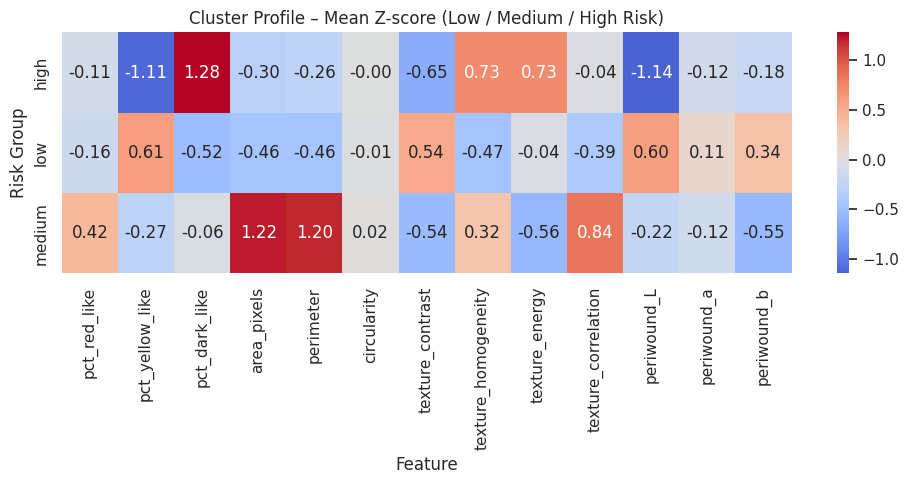

In [42]:
# standardized dataframe
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
X_scaled_df["risk_level"] = df["risk_level"]

cluster_profile = X_scaled_df.groupby("risk_level")[feature_cols].mean()

plt.figure(figsize=(10,5))
sns.heatmap(cluster_profile, annot=True, fmt=".2f",
            cmap="coolwarm", center=0)
plt.title("Cluster Profile – Mean Z-score (Low / Medium / High Risk)")
plt.xlabel("Feature")
plt.ylabel("Risk Group")
plt.tight_layout()
plt.show()


In [43]:
df.to_csv("wound_features_with_risk.csv", index=False)
print("Đã lưu file wound_features_with_risk.csv")

Đã lưu file wound_features_with_risk.csv
